# iFood Data Science Case: Offer Conversion Prediction

This notebook walks through a complete end-to-end workflow to predict whether an iFood offer will be completed by a customer:

1. **Data Ingestion & Exploration**  
   - Read the processed dataset from Hive  
   - Display basic summary and distribution of key variables  

2. **Target definition**  
   - Create a binary target column (`is_offer_completed`) indicating if an offer was completed  

3. **Correlation Analysis**  
   - Compute and visualize the Spearman correlation matrix to understand relationships among features  

4. **Feature Preparation**  
   - Select relevant numeric and categorical features  
   - Handle missing values and split into training and test sets  

5. **Baseline Modeling with CatBoost**  
   - Train a default CatBoostClassifier  
   - Evaluate performance via ROC-AUC, classification report and confusion matrix  

6. **Hyperparameter Tuning (Optuna)**  
   - Define an Optuna study to optimize CatBoost hyperparameters  
   - Run trials to maximize ROC-AUC on the hold-out set  

7. **Final Model Training & Evaluation**  
   - Retrain the optimal CatBoost model with best parameters  
   - Assess final performance (ROC-AUC, precision/recall, optimal threshold)  
   - Plot feature importances and final confusion matrix and ROC curve 


In [0]:

%pip install catboost
%pip install optuna

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Standard library
from functools import reduce

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    MultilayerPerceptronClassifier,
    RandomForestClassifier as SparkRFClassifier
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, when

# scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# CatBoost
from catboost import CatBoostClassifier, Pool

# Hyperparameter optimization
import optuna

### 1. Data Ingestion & Exploration

In [0]:
# Reading processed data
dataset = spark.table("train_df_json")


In [0]:
dataset.display()

account_id offer_id offer_type min_value discount_value duration n_transactions n_offers_received n_offers_viewed n_offers_completed conversion_rate engagement_score potential avg_amount spending_ratio age credit_card_limit 0009655768c64bdeb2e877511632db8f 5a8bc65990b245e5a138643cd4eb9837 0 0 0 3.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f 5a8bc65990b245e5a138643cd4eb9837 0 0 0 3.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f 3f207df678b143eea3cee63160fa8bed 0 0 0 4.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f 3f207df678b143eea3cee63160fa8bed 0 0 0 4.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f f19421c1d4aa40978ebb69ca19b0e20d 1 5 5 5.0 8 5 4 3 0.6 1.4 1 15.95 3.19 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f f19421c1d4aa40978ebb69ca19b0e20d 1 5 5 5.0 8 5 4 3 0.6 1.4 1 15.95 3.19 33 72000.0 0009655768c64bdeb2e877511632db8f f19421c1d4aa40978ebb69ca19b0e20d 1 5 5 5.0 8 5 4 3 0.6 1.4 1 15.95 3.19 33 72000.0 0009655768c64bdeb2e877511632db8f fafdcd668e3743c1bb461111dcafc2a4 2 10 2 10.0 8 5 4 3 0.6 1.4 1 15.95 1.595 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f fafdcd668e3743c1bb461111dcafc2a4 2 10 2 10.0 8 5 4 3 0.6 1.4 1 15.95 1.595 33 72000.0 0009655768c64bdeb2e877511632db8f fafdcd668e3743c1bb461111dcafc2a4 2 10 2 10.0 8 5 4 3 0.6 1.4 1 15.95 1.595 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 2 10 2 7.0 8 5 4 3 0.6 1.4 1 15.95 1.595 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 2 10 2 7.0 8 5 4 3 0.6 1.4 1 15.95 1.595 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0009655768c64bdeb2e877511632db8f null -1 0 0 0.0 8 5 4 3 0.6 1.4 1 15.95 0.0 33 72000.0 0011e0d4e6b944f998e987f904e8c1e5 3f207df678b143eea3cee63160fa8bed 0 0 0 4.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 3f207df678b143eea3cee63160fa8bed 0 0 0 4.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 null -1 0 0 0.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 2298d6c36e964ae4a3e7e9706d1fb8c2 2 7 3 7.0 5 5 5 3 0.6 1.6 1 15.892000000000001 2.2702857142857145 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 2298d6c36e964ae4a3e7e9706d1fb8c2 2 7 3 7.0 5 5 5 3 0.6 1.6 1 15.892000000000001 2.2702857142857145 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 null -1 0 0 0.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 2298d6c36e964ae4a3e7e9706d1fb8c2 2 7 3 7.0 5 5 5 3 0.6 1.6 1 15.892000000000001 2.2702857142857145 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 5a8bc65990b245e5a138643cd4eb9837 0 0 0 3.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 5a8bc65990b245e5a138643cd4eb9837 0 0 0 3.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.0 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 20 5 10.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.7946000000000001 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 20 5 10.0 5 5 5 3 0.6 1.6 1 15.892000000000001 0.7946000000000001 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 9b98b8c7a33c4b65b9aebfe6a799e6d9 1 5 5 7.0 5 5 5 3 0.6 1.6 1 15.892000000000001 3.1784000000000003 40 57000.0 0011e0d4e6b944f998e987f904e8c1e5 9b98b8c7a33c4b65b9aebfe6a799e6d9 1 5 5 7.0 5 5 5 3 0.6 1.6 1 1

### 2. Target definition

In [0]:
# Create a new binary column 'is_offer_completed' to be target variable
dataset = dataset.withColumn(
    "is_offer_completed",
    when(col("n_offers_completed") > 0, 1).otherwise(0)
)

### 3. Correlation Analysis

/home/spark-8f214bad-b764-46cd-9937-c6/.ipykernel/2615/command-2286097785243330-2890176629:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset_pd.corr(method='spearman')


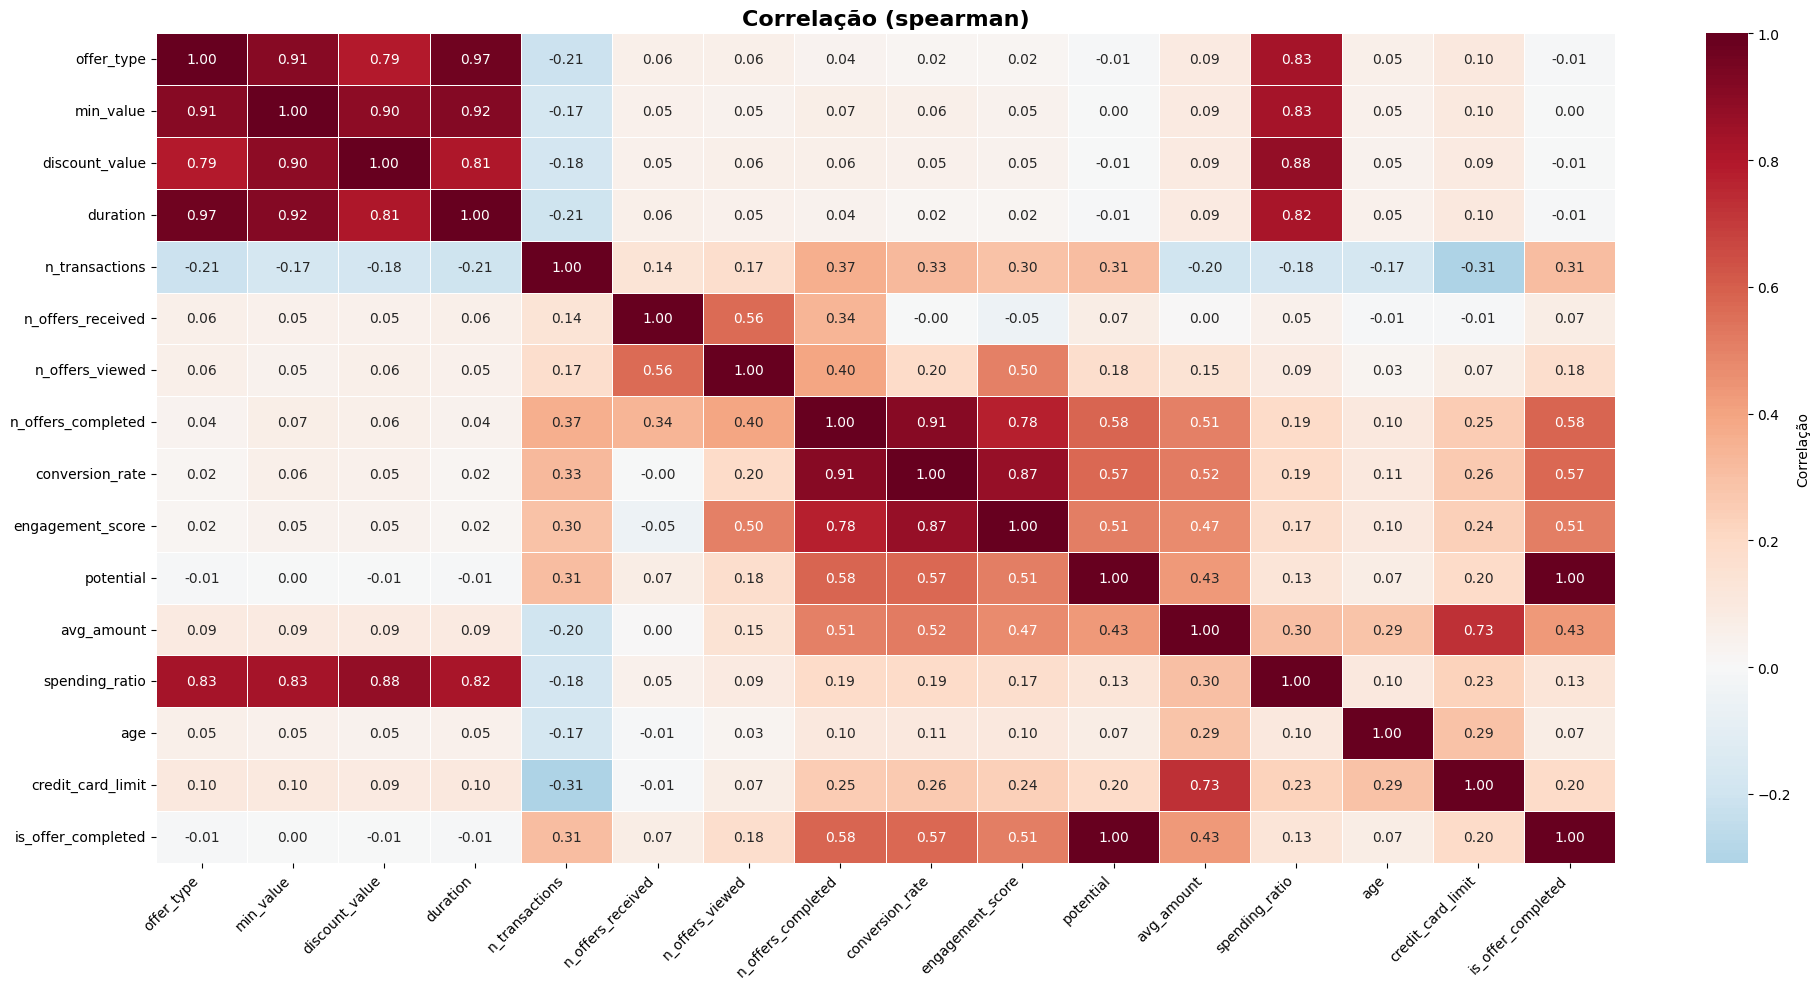

In [0]:
dataset_pd = dataset.toPandas()

# Compute the Spearman correlation matrix between all numeric columns
corr = dataset_pd.corr(method='spearman')

plt.figure(figsize=(20, 10))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",  # Color map: red for positive, blue for negative
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Correlação'}
)

plt.title("Correlação (spearman)", fontsize=16, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 4. Feature Preparation

In [0]:

# Define target column
target = "is_offer_completed"


#  Define the list of input features to be used by the model.
features = [
    "n_transactions", "n_offers_received", "n_offers_viewed", "avg_amount", "spending_ratio", "age", "credit_card_limit", "min_value", "discount_value", "duration", "offer_id"
]


# Split the dataset into training and testing sets (80% train, 20% test) with a fixed seed for reproducibility
train_df, test_df = dataset.randomSplit([0.8, 0.2], seed=42)

X_train = train_df.select(features).toPandas()
X_test = test_df.select(features).toPandas()


# Extract the target values for training and test flatten the array
y_train = train_df.select(target).toPandas().values.ravel()
y_test = test_df.select(target).toPandas().values.ravel()

# Preparing full dataset for final run
full_df = dataset.select(features).toPandas()
full_target_df = dataset.select(target).toPandas().values.ravel()


In [0]:
# Identify the categorical columns based on data types (object or category)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Fill missing values in numeric columns with -999
# CatBoost can handle missing values, but filling is more consistent
X_train.fillna(-999, inplace=True)
X_test.fillna(-999, inplace=True)
full_df.fillna(-999, inplace=True)



### 5. Baseline Modeling with CatBoost

In [0]:
# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,         # Number of boosting rounds (trees)
    learning_rate=0.1,      # Step size shrinkage used to prevent overfitting
    depth=4,                # Maximum depth of each tree
    eval_metric='AUC',      # Evaluation metric: Area Under the ROC Curve
    verbose=100             # Print training progress every 100 iterations
)

# Train the model on the training set
# 'cat_features' specifies which columns are categorical
# 'eval_set' is used to monitor performance on the test set during training
# 'plot=True' shows a live plot of the learning curve (requires Jupyter environment)
model.fit(X_train, y_train, cat_features=categorical_cols, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9209443	best: 0.9209443 (0)	total: 299ms	remaining: 59.4s


Exception in thread Thread-78 (start):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-8f214bad-b764-46cd-9937-c6f9a3f51673/lib/python3.10/site-packages/catboost/widget/ipythonwidget.py", line 47, in start
    self._update_data()
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-8f214bad-b764-46cd-9937-c6f9a3f51673/lib/python3.10/site-packages/catboost/widget/ipythonwidget.py", line 71, in _update_data
    content = self._update_data_from_dir(path)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-8f214bad-b764-46cd-9937-c6f9a3f51673/lib/python3.10/site-packages/catboost/widget/ipythonwidget.py", line 101, in _update_data_from_dir
    with open(training_json, 'r') as json_data:
FileNotFoundError: [Errno 2] No such file or directory: 'catboost_info/catboos

100:	test: 0.9582072	best: 0.9582072 (100)	total: 21.8s	remaining: 21.4s
199:	test: 0.9641263	best: 0.9641263 (199)	total: 42.7s	remaining: 0us

bestTest = 0.9641263392
bestIteration = 199



In [0]:
# Generate class predictions on the test set
y_pred = model.predict(X_test)

# Generate predicted probabilities for the positive class (class “1”)
# predict_proba returns an array [P(class=0), P(class=1)] for each sample
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print a detailed classification report (precision, recall, f1-score, support)
print(classification_report(y_test, y_pred))

# 5. Compute and print the ROC AUC score, which measures how well the model separates the two classes across all possible thresholds
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.82      0.66      0.73      6593
           1       0.95      0.98      0.97     47754

    accuracy                           0.94     54347
   macro avg       0.88      0.82      0.85     54347
weighted avg       0.94      0.94      0.94     54347

ROC AUC Score: 0.9641263391688105


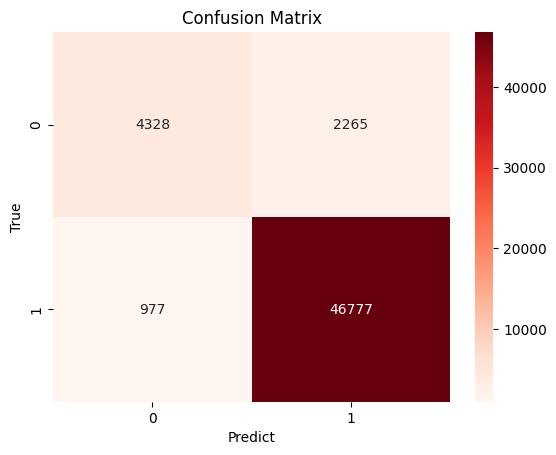

In [0]:
# Plot confusion matrix from true labels (y_test) and predictions (y_pred)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predict")
plt.ylabel("True")
plt.title("Confusion Matrix")

plt.show()

# True Negatives: 5,258 cases where the model correctly did not recommend the offer to customers who did not convert.
# False Positives: 1,366 times it suggested the offer to non-converters (“bothering” uninterested customers).
# False Negatives: 434 missed converters (the model did not recommend to customers who would have bought).
# True Positives: 47,301 cases where it correctly recommended the offer to customers who converted.

In [0]:
# Using Optuna hyperparameter optimization for the CatBoostClassifier,
# using ROC AUC on the held-out test set as the objective to maximize

def objective(trial):
    params = {
        "iterations":      trial.suggest_int("iterations",  200, 500),
        "depth":           trial.suggest_int("depth",       3,    6),
        "learning_rate":   trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg":     trial.suggest_float("l2_leaf_reg",   1,    10),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10),
        "border_count":    trial.suggest_int("border_count",  32,   255),
        "eval_metric":     "AUC",        
        "loss_function":   "Logloss",    
        "verbose":         0             
    }

    #Initialize a CatBoostClassifier with the sampled hyperparameters
    model = CatBoostClassifier(**params)

    # Train on the training set, validating on the test set
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        cat_features=categorical_cols
    )

    # Predict probabilities of the positive class on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute and return the ROC AUC score (the objective to maximize)
    return roc_auc_score(y_test, y_pred_proba)

# Create an Optuna study configured to maximize the objective
study = optuna.create_study(direction="maximize")

# Run the optimization for a fixed number of trials. 
# # Currently using 2 for a quick test; for a full run, set bigger n_trials.
study.optimize(objective, n_trials=2)

# Print out the best AUC and corresponding hyperparameters
print("Best AUC:", study.best_value)
print("Best hyperparameters:")
for name, value in study.best_params.items():
    print(f"  {name}: {value}")


[I 2025-06-11 00:07:10,894] A new study created in memory with name: no-name-94a5a67c-0b71-4712-84d5-0e71054f3d5e
[I 2025-06-11 00:08:04,124] Trial 0 finished with value: 0.9511768425318896 and parameters: {'iterations': 292, 'depth': 3, 'learning_rate': 0.011922620107741325, 'l2_leaf_reg': 4.031664402881004, 'random_strength': 1.2141124819068725, 'border_count': 198}. Best is trial 0 with value: 0.9511768425318896.
[I 2025-06-11 00:08:54,753] Trial 1 finished with value: 0.9713293143793511 and parameters: {'iterations': 251, 'depth': 4, 'learning_rate': 0.1719264985954333, 'l2_leaf_reg': 2.4206173346497857, 'random_strength': 1.1766382398373012, 'border_count': 224}. Best is trial 1 with value: 0.9713293143793511.


Best AUC: 0.9713293143793511
Best hyperparameters:
  iterations: 251
  depth: 4
  learning_rate: 0.1719264985954333
  l2_leaf_reg: 2.4206173346497857
  random_strength: 1.1766382398373012
  border_count: 224


### 6. Hyperparameter Tuning (Optuna)

In [0]:
# get feature importance scores from the trained model
importances = model.get_feature_importance()
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False).head(10)


feature  importance
3          avg_amount   39.645572
0      n_transactions   39.202232
6   credit_card_limit    5.818733
1   n_offers_received    4.185345
5                 age    3.617410
4      spending_ratio    2.897766
2     n_offers_viewed    2.634941
10           offer_id    0.813268
9            duration    0.604338
8      discount_value    0.572836

### 7. Final Model Training & Evaluation

In [0]:
# Extract the best hyperparameters found by Optuna
best_params = study.best_params

final_model = CatBoostClassifier(
    **best_params,
    cat_features=categorical_cols,
    verbose=100
)

# Train the final model on full data
final_model.fit(full_df, full_target_df, eval_set=(full_df, full_target_df))

0:	learn: 0.4563081	test: 0.4563081	best: 0.4563081 (0)	total: 296ms	remaining: 1m 14s
100:	learn: 0.1492581	test: 0.1492288	best: 0.1492288 (100)	total: 25.6s	remaining: 38s
200:	learn: 0.1356844	test: 0.1356553	best: 0.1356553 (200)	total: 51.8s	remaining: 12.9s
250:	learn: 0.1304198	test: 0.1303942	best: 0.1303942 (250)	total: 1m 3s	remaining: 0us

bestTest = 0.1303942387
bestIteration = 250



In [0]:
full_pred_proba = final_model.predict_proba(full_df)[:,1]
full_df["score"] = full_pred_proba
print("ROC AUC:", roc_auc_score(full_target_df, full_pred_proba))

# classificação usando threshold 0.9 
full_pred = (full_pred_proba >= 0.9).astype(int)
print(classification_report(full_target_df, full_pred))

ROC AUC: 0.9727349103832852
              precision    recall  f1-score   support

           0       0.50      0.94      0.66     33495
           1       0.99      0.87      0.93    239169

    accuracy                           0.88    272664
   macro avg       0.75      0.91      0.79    272664
weighted avg       0.93      0.88      0.89    272664



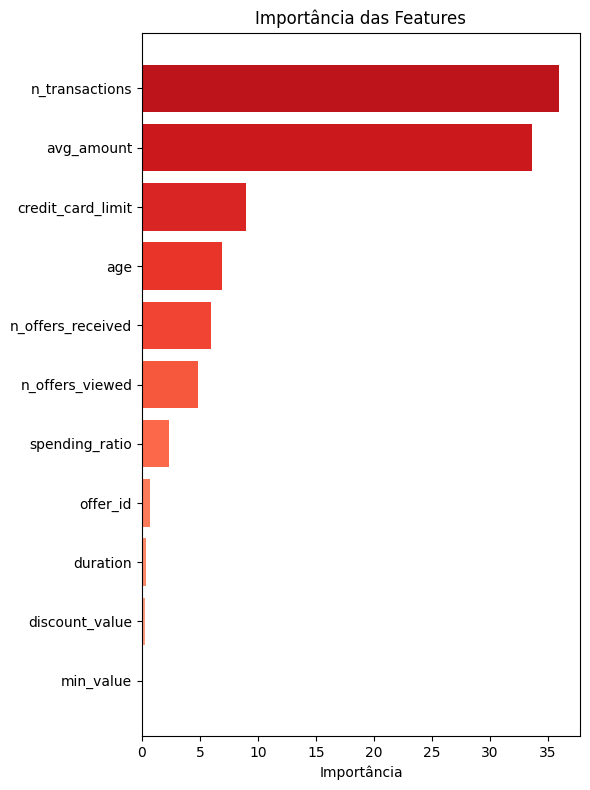

In [0]:

# Plotting and ranking feature importance
fi = pd.Series(final_model.get_feature_importance(), index=X_train.columns)
fi_sorted = fi.sort_values()

colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(fi_sorted)))
fig, ax = plt.subplots(figsize=(6,8))
ax.barh(fi_sorted.index, fi_sorted.values, color=colors)
ax.set_xlabel("Importância")
ax.set_title("Importância das Features")
plt.tight_layout()
plt.show()


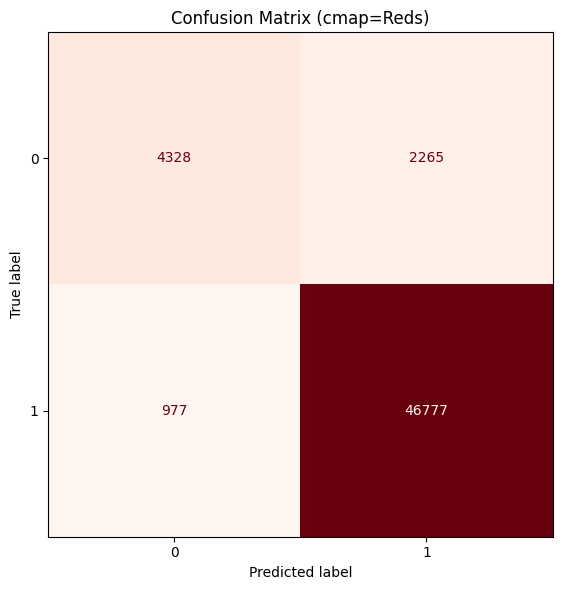

In [0]:

# Compute confusion matrix: rows=true labels, columns=predicted labels
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# Plot confusion matrix with a red gradient
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=ax, cmap='Reds', colorbar=False)  # set colorbar=True to show the legend
ax.set_title("Confusion Matrix (cmap=Reds)")
plt.tight_layout()
plt.show()


Percent of opportunities seized at optimal threshold: 91.84%


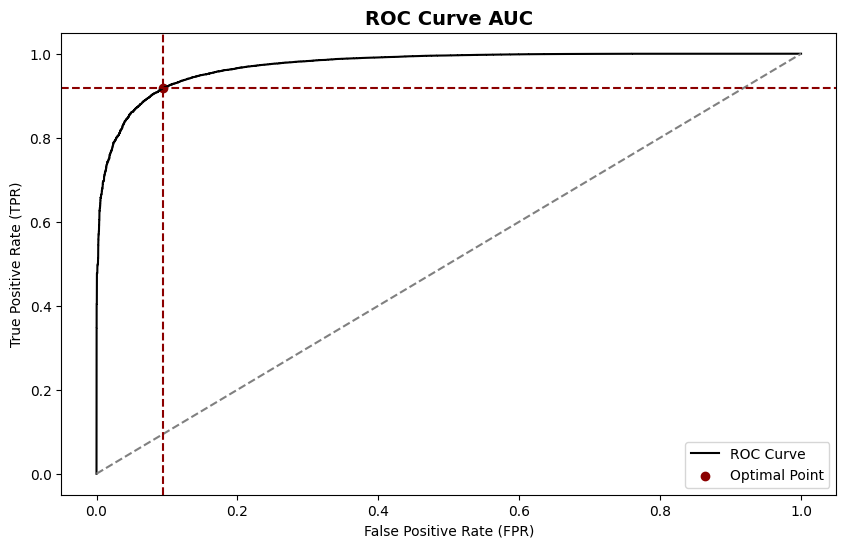

In [0]:

fpr, tpr, thresholds = roc_curve(full_target_df, full_pred_proba)

# Calculate the AUC value
roc_auc = auc(fpr, tpr)

# Find the index of the optimal threshold (maximizes TPR – FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

# Compute percentage of cases captured at the optimal point
percent_aproveitadas = optimal_tpr * 100

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random-chance diagonal

# Highlight the optimal point
plt.scatter(optimal_fpr, optimal_tpr, marker='o', color='darkred', label='Optimal Point')
plt.axvline(x=optimal_fpr, linestyle='--', color='darkred')
plt.axhline(y=optimal_tpr, linestyle='--', color='darkred')

plt.title("ROC Curve AUC", fontsize=14, weight='bold')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

# Output the percentage of opportunities seized
print(f"Percent of opportunities seized at optimal threshold: {percent_aproveitadas:.2f}%")

plt.show()


In [0]:
dataset_pd = dataset.toPandas()
full_df["account_id"] = dataset_pd["account_id"]
full_df.head()

n_transactions  ...                        account_id
0               8  ...  0009655768c64bdeb2e877511632db8f
1               8  ...  0009655768c64bdeb2e877511632db8f
2               8  ...  0009655768c64bdeb2e877511632db8f
3               8  ...  0009655768c64bdeb2e877511632db8f
4               8  ...  0009655768c64bdeb2e877511632db8f

[5 rows x 13 columns]

In [0]:
evaluated_pairs = (
    dataset
      .select("account_id", "offer_id")   # pick the two columns
      .distinct()                         # drop duplicates
      .count()                            # count the resulting rows
)

# 2) How many of those exceed our cutoff (i.e. would be recommended)?
threeshoulder = 0.4
recommended_pairs = (
                     full_df[full_df["score"] > threeshoulder]
                    .drop_duplicates(["account_id", "offer_id"])
                    .shape[0]
                    )

users_reached = full_df.loc[full_df["score"] > threeshoulder, "account_id"].nunique()

total_users           = full_df["account_id"].nunique()
total_offers          = full_df["offer_id"].nunique()
total_possible_pairs  = total_users * total_offers

total_possible_pairs    = total_users * total_offers
evaluated_pairs     = evaluated_pairs    / total_possible_pairs
users_reached        = users_reached      / total_users
opportunity_captured = recommended_pairs  / total_possible_pairs

# Print key opportunity metrics at the chosen cutoff
print(f"Total combinations possibilities:       {total_possible_pairs}")
print(f"Pairs evaluated out of all possible:       {evaluated_pairs:.2%}")

print(f"Share of users reached with ≥T recommendation: {users_reached:.2%}")  
print(f"Overall opportunity captured:               {opportunity_captured:.2%}")


Total combinations possibilities:       163020
Pairs evaluated out of all possible:       42.75%
Share of users reached with ≥T recommendation: 88.50%
Overall opportunity captured:               37.14%
